In [1812]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Importing Data

In [1813]:
# import TCP23_data.xlsx sheet Q1 E-bike Sales as df starting at row 6 and end at row 22
df = pd.read_excel('TCP23_data.xlsx', sheet_name='Q1 E-bike Sales', skiprows=6, nrows=17)

locations = ['US', 'Europe', 'France', 'China', 'India', 'Japan']

#rename rows to Year, US, Europe, France, China, India, Japan
df.columns = ['Year'] + locations

#focus on US and Europe data
df = df[['Year', 'US', 'Europe']]
locations = ['US', 'Europe']

# convert year data to int
df['Year'] = df['Year'].astype(int)

## Splitting Data by Location

In [1814]:
# separate into data frames for each location with year
dataframes = {location: df[['Year', location]] for location in locations}

# for each df, drop all rows with no data
for location, df in dataframes.items():
    dataframes[location] = df[df[location] != '--']

# convert all values to numbers
for location, df in dataframes.items():
    dataframes[location][location] = pd.to_numeric(df[location])

# define market size for locations in 1000s of people
market_size = {'US': 45000, 'Europe': 40794, 'UK': 10700 }

# show us data head
print(dataframes['Europe'].head())

# divide data by market size
for location, df in dataframes.items():
    dataframes[location][location] = df[location] / market_size[location]

# for each dataframe create a column for cumulative sum
for location, df in dataframes.items():
    dataframes[location]['cum_sum'] = df[location].cumsum()

# for each dataframe create a new column with year minus first year
for location, df in dataframes.items():
    dataframes[location]['year_diff'] = df['Year'] - df['Year'].iloc[0]

# show us data head
print(dataframes['Europe'].head())

   Year  Europe
0  2006      98
1  2007     173
2  2008     279
3  2009     422
4  2010     588
   Year    Europe   cum_sum  year_diff
0  2006  0.002402  0.002402          0
1  2007  0.004241  0.006643          1
2  2008  0.006839  0.013482          2
3  2009  0.010345  0.023827          3
4  2010  0.014414  0.038241          4


## Defining Bass Diffusion Equation

In [1815]:
# define bass diffusion model
def bass_diffusion_model(x, p, q):
    return (1.0- np.exp(-1.0 * (p + q) * x))/(1 + q / p * np.exp(-1.0 * (p + q) * x))

## Regression for US Data

C:\Users\kevin\AppData\Local\Temp\ipykernel_16944\4113519518.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  US_results = US_results.append(preds, ignore_index=True)


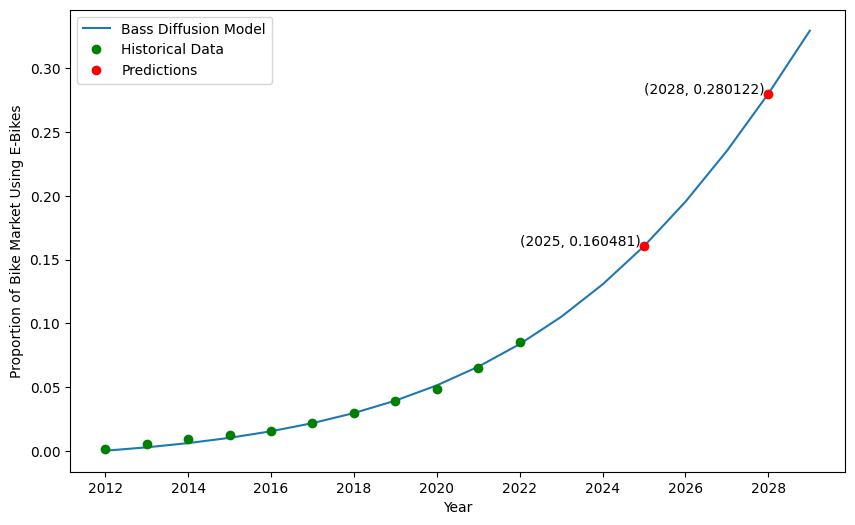

US Parameters: [0.00237033 0.22569981]


In [1816]:
location = 'US'

# get the last year in the location data
last_year = dataframes[location]['Year'].iloc[-1]

# get the first year in the location data
first_year = dataframes[location]['Year'].iloc[0]

# fit to data
bass_popt, bass_pcov = curve_fit(bass_diffusion_model, dataframes[location]['year_diff'], dataframes[location]['cum_sum'], p0=[0.003, 0.17], maxfev=100000)

# for sensitivity analysis
# increase p and q by 10% and -10%
bass_popt_10pplus = [bass_popt[0] * 1.1, bass_popt[1]]
bass_popt_10pminus = [bass_popt[0] * 0.9, bass_popt[1]]
bass_popt_10qplus = [bass_popt[0], bass_popt[1] * 1.1]
bass_popt_10qminus = [bass_popt[0], bass_popt[1] * 0.9]

# add columns for predictions
dataframes[location]['bass'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt)
dataframes[location]['bass_10pplus'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt_10pplus)
dataframes[location]['bass_10pminus'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt_10pminus)
dataframes[location]['bass_10qplus'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt_10qplus)
dataframes[location]['bass_10qminus'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt_10qminus)

# take results dataframe as Year, year_diff, and bass, bass_10pplus, bass_10pminus, bass_10qplus, bass_10qminus
US_results = dataframes[location][['Year', 'year_diff', 'bass', 'bass_10pplus', 'bass_10pminus', 'bass_10qplus', 'bass_10qminus']]

# create new df with years from last year+1 to 2030
preds = pd.DataFrame({'Year': range(last_year+1, 2030)})
preds['year_diff'] = preds['Year'] - first_year
preds['bass'] = bass_diffusion_model(preds['year_diff'], *bass_popt)
preds['bass_10pplus'] = bass_diffusion_model(preds['year_diff'], *bass_popt_10pplus)
preds['bass_10pminus'] = bass_diffusion_model(preds['year_diff'], *bass_popt_10pminus)
preds['bass_10qplus'] = bass_diffusion_model(preds['year_diff'], *bass_popt_10qplus)
preds['bass_10qminus'] = bass_diffusion_model(preds['year_diff'], *bass_popt_10qminus)

# add preds to US_results
US_results = US_results.append(preds, ignore_index=True)

# plot results year against bass predictions and data
plt.plot(US_results['Year'], US_results['bass'])
plt.plot(dataframes[location]['Year'], dataframes[location]['cum_sum'], 'o', color='green')

#label the coordinate at x=2025 with (year, bass) to 6 decimal places
pred_2025 = US_results[US_results['Year'] == 2025]['bass'].iloc[0]
plt.plot(2025, pred_2025, 'o', color='red')
plt.annotate(f'(2025, {pred_2025:.6f})', xy=(2022, pred_2025))

#label the coordinate at x = 2028
pred_2028 = US_results[US_results['Year'] == 2028]['bass'].iloc[0]
plt.plot(2028, pred_2028, 'o', color='red')
plt.annotate(f'(2028, {pred_2028:.6f})', xy=(2025, pred_2028))

# set ticks to be every 2 years
plt.xticks(range(dataframes[location]['Year'].iloc[0], 2030, 2))

# label X axis as Year
plt.xlabel('Year')

# label Y axis as Proportion of Bike Market Using E-Bikes
plt.ylabel('Proportion of Bike Market Using E-Bikes')

# add legend with blue line for bass model, orange dots for original data, and red dots for predictions
plt.legend(['Bass Diffusion Model', 'Historical Data', 'Predictions'])

plt.show()
print("US Parameters: " + str(bass_popt))

In [1817]:
# change in bass
US_results['bass_change'] = US_results['bass'].diff()
US_results['bass_10pplus'] = US_results['bass_10pplus'].diff()
US_results['bass_10pminus'] = US_results['bass_10pminus'].diff()
US_results['bass_10qplus'] = US_results['bass_10qplus'].diff()
US_results['bass_10qminus'] = US_results['bass_10qminus'].diff()

# find the percent change from bass to each of the sensitivity analysis basses
US_results['bass_10pplus'] = (US_results['bass_10pplus'] - US_results['bass_change']) / US_results['bass']
US_results['bass_10pminus'] = (US_results['bass_10pminus'] - US_results['bass_change']) / US_results['bass']
US_results['bass_10qplus'] = (US_results['bass_10qplus'] - US_results['bass_change']) / US_results['bass']
US_results['bass_10qminus'] = (US_results['bass_10qminus'] - US_results['bass_change']) / US_results['bass']

# add bikes sold as bass_change times market size
US_results['bikes_sold'] = US_results['bass_change'] * market_size[location]
US_results

,Year,year_diff,bass,bass_10pplus,bass_10pminus,bass_10qplus,bass_10qminus,bass_change,bikes_sold
0,2012,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,1,0.002655,0.099843,-0.099871,0.011772,-0.011594,0.002655,119.490382
2,2014,2,0.005971,0.055221,-0.055277,0.019277,-0.018610,0.003316,149.204392
3,2015,3,0.010105,0.040453,-0.040536,0.023709,-0.022403,0.004134,186.026627
4,2016,4,0.015249,0.033100,-0.033215,0.027454,-0.025396,0.005144,231.500494
5,2017,5,0.021636,0.028664,-0.028817,0.030945,-0.028042,0.006387,287.417121
6,2018,6,0.029543,0.025633,-0.025833,0.034277,-0.030459,0.007907,355.805109
7,2019,7,0.039296,0.023349,-0.023607,0.037428,-0.032661,0.009753,438.885275
8,2020,8,0.051273,0.021473,-0.021800,0.040319,-0.034619,0.011977,538.971138
9,2021,9,0.065902,0.019808,-0.020215,0.042825,-0.036276,0.014629,658.291174


## Regression for Europe Data

C:\Users\kevin\AppData\Local\Temp\ipykernel_16944\1000837373.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  europe_results = europe_results.append(preds, ignore_index=True)


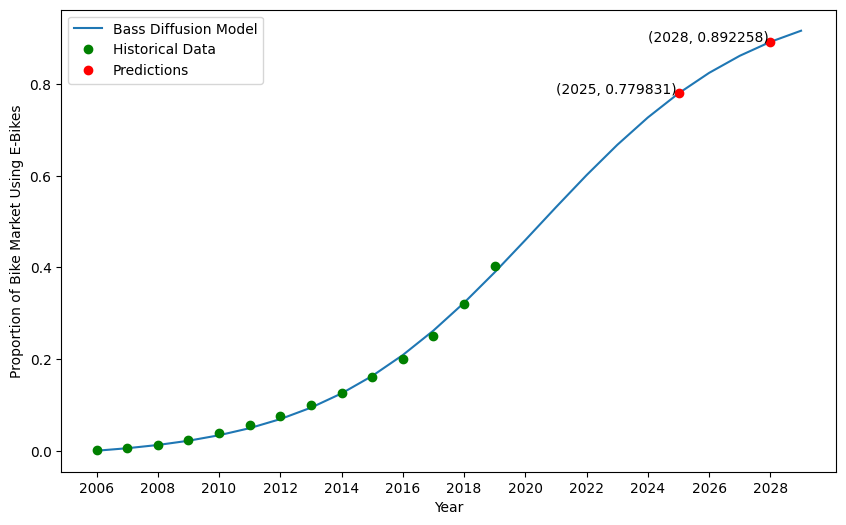

Europe Parameters: [0.00471138 0.27750277]


In [1818]:
location = 'Europe'

# get the last year in the location data
last_year = dataframes[location]['Year'].iloc[-1]

# get the first year in the location data
first_year = dataframes[location]['Year'].iloc[0]

# define bass diffusion model
def bass_diffusion_model(x, p, q):
    return (1.0- np.exp(-1.0 * (p + q) * x))/(1 + q / p * np.exp(-1.0 * (p + q) * x))

# fit to data
bass_popt, bass_pcov = curve_fit(bass_diffusion_model, dataframes[location]['year_diff'], dataframes[location]['cum_sum'], p0=[0.003, 0.17], maxfev=100000)

# for sensitivity analysis
# increase p and q by 10% and -10%
bass_popt_10pplus = [bass_popt[0] * 1.1, bass_popt[1]]
bass_popt_10pminus = [bass_popt[0] * 0.9, bass_popt[1]]
bass_popt_10qplus = [bass_popt[0], bass_popt[1] * 1.1]
bass_popt_10qminus = [bass_popt[0], bass_popt[1] * 0.9]

# add columns for predictions
dataframes[location]['bass'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt)
dataframes[location]['bass_10pplus'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt_10pplus)
dataframes[location]['bass_10pminus'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt_10pminus)
dataframes[location]['bass_10qplus'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt_10qplus)
dataframes[location]['bass_10qminus'] = bass_diffusion_model(dataframes[location]['year_diff'], *bass_popt_10qminus)

# take results dataframe as Year, year_diff, bass, bass_10pplus, bass_10pminus, bass_10qplus, bass_10qminus
europe_results = dataframes[location][['Year', 'year_diff', 'bass', 'bass_10pplus', 'bass_10pminus', 'bass_10qplus', 'bass_10qminus']]

# create new df with years from last year to 2030
preds = pd.DataFrame({'Year': range(last_year+1, 2030)})
preds['year_diff'] = preds['Year'] - first_year
preds['bass'] = bass_diffusion_model(preds['year_diff'], *bass_popt)
preds['bass_10pplus'] = bass_diffusion_model(preds['year_diff'], *bass_popt_10pplus)
preds['bass_10pminus'] = bass_diffusion_model(preds['year_diff'], *bass_popt_10pminus)
preds['bass_10qplus'] = bass_diffusion_model(preds['year_diff'], *bass_popt_10qplus)
preds['bass_10qminus'] = bass_diffusion_model(preds['year_diff'], *bass_popt_10qminus)

# add preds to results
europe_results = europe_results.append(preds, ignore_index=True)
# plot results year against bass predictions and data
plt.plot(europe_results['Year'], europe_results['bass'])
plt.plot(dataframes[location]['Year'], dataframes[location]['cum_sum'], 'o', color='green')

#label the coordinate at x=2025 with (year, bass) to 6 decimal places
pred_2025 = europe_results[europe_results['Year'] == 2025]['bass'].iloc[0]
plt.plot(2025, pred_2025, 'o', color='red')
plt.annotate(f'(2025, {pred_2025:.6f})', xy=(2021, pred_2025))

#label the coordinate at x = 2028
pred_2028 = europe_results[europe_results['Year'] == 2028]['bass'].iloc[0]
plt.plot(2028, pred_2028, 'o', color='red')
plt.annotate(f'(2028, {pred_2028:.6f})', xy=(2024, pred_2028))

# set ticks to be every 2 years
plt.xticks(range(dataframes[location]['Year'].iloc[0], 2030, 2))

# label X axis as Year
plt.xlabel('Year')

# label Y axis as Proportion of Bike Market Using E-Bikes
plt.ylabel('Proportion of Bike Market Using E-Bikes')

# add legend with blue line for bass model, orange dots for original data, and red dots for predictions
plt.legend(['Bass Diffusion Model', 'Historical Data', 'Predictions'])

plt.show()
print("Europe Parameters: " + str(bass_popt))

In [1819]:
# change in bass
europe_results['bass_change'] = europe_results['bass'].diff()
europe_results['bass_10pplus'] = europe_results['bass_10pplus'].diff()
europe_results['bass_10pminus'] = europe_results['bass_10pminus'].diff()
europe_results['bass_10qplus'] = europe_results['bass_10qplus'].diff()
europe_results['bass_10qminus'] = europe_results['bass_10qminus'].diff()

# find the percent change from bass to each of the sensitivity analysis basses
europe_results['bass_10pplus'] = (europe_results['bass_10pplus'] - europe_results['bass_change']) / europe_results['bass']
europe_results['bass_10pminus'] = (europe_results['bass_10pminus'] - europe_results['bass_change']) / europe_results['bass']
europe_results['bass_10qplus'] = (europe_results['bass_10qplus'] - europe_results['bass_change']) / europe_results['bass']
europe_results['bass_10qminus'] = (europe_results['bass_10qminus'] - europe_results['bass_change']) / europe_results['bass']

# add bikes sold as bass_change times market size
europe_results['bikes_sold'] = europe_results['bass_change'] * market_size[location]
europe_results

,Year,year_diff,bass,bass_10pplus,bass_10pminus,bass_10qplus,bass_10qminus,bass_change,bikes_sold
0,2006,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2007,1,0.005414,0.099674,-0.099733,0.014585,-0.014314,0.005414,220.855985
2,2008,2,0.012503,0.056026,-0.056148,0.024228,-0.023209,0.007089,289.207025
3,2009,3,0.021750,0.041458,-0.041647,0.030192,-0.028195,0.009247,377.207537
4,2010,4,0.033748,0.034013,-0.034286,0.035211,-0.032093,0.011998,489.439777
5,2011,5,0.049211,0.029263,-0.029640,0.039655,-0.035356,0.015463,630.808526
6,2012,6,0.068969,0.025701,-0.026205,0.043436,-0.038016,0.019758,806.000481
7,2013,7,0.093937,0.022657,-0.023308,0.046282,-0.039965,0.024968,1018.530062
8,2014,8,0.125051,0.019784,-0.020597,0.047824,-0.041034,0.031114,1269.277323
9,2015,9,0.163158,0.016897,-0.017874,0.047656,-0.041031,0.038107,1554.552174
